<a href="https://colab.research.google.com/github/ozakbas/Computer-Vision-Experiments/blob/main/multilayer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1) Preprocessing





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load SVHN dataset
import scipy.io as sio
import numpy as np

def load_data(path):
    data = sio.loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('/content/drive/MyDrive/train_32x32.mat')
X_test, y_test   = load_data('/content/drive/MyDrive/test_32x32.mat')


# Summarize dataset (count, shape, min/max value)

label, count = np.unique(y_train, return_counts=True)
print("Occurances of labels in training set:",dict(zip(label, count)))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print('Train X Min: {}, Max: {}'.format(X_train.min(), X_train.max()))
print('Train Y Min: {}, Max: {}'.format(y_train.min(), y_train.max()))

Occurances of labels in training set: {1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}
X_train shape: (32, 32, 3, 73257)
y_train shape: (73257, 1)
X_test shape: (32, 32, 3, 26032)
y_test shape: (26032, 1)
Train X Min: 0, Max: 255
Train Y Min: 1, Max: 10


In [ ]:
#Change input shape
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

y_train = y_train.reshape((y_train.shape[0]),)
y_test = y_test.reshape((y_test.shape[0]),)

print("Shapes after fixing axis: ", X_train.shape, X_test.shape)
print("y_test shape: ", y_train.shape)

Shapes after fixing axis:  (73257, 32, 32, 3) (26032, 32, 32, 3)
y_test shape:  (73257,)


In [ ]:
# Normalize dataset
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('Min: {}, Max: {}'.format(X_train.min(), X_train.max()))

Min: 0.0, Max: 1.0


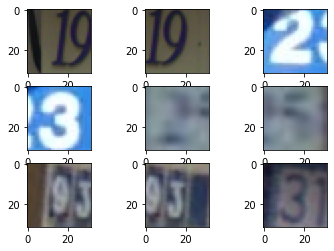

In [ ]:
# Visualize some samples
from matplotlib import pyplot

for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()


In [ ]:
# Flatten the data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0],-1)

print(X_train.shape)

(73257, 3072)


In [ ]:
# Change values 10 with 0
y_train[y_train > 9] = 0
y_test[y_test > 9] = 0
print('Min: {}, Max: {}'.format(y_train.min(), y_train.max()))

Min: 0, Max: 9


#2) Modelling



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam, SGD
import numpy

# Build the model
model = Sequential()
model.add(Dense(512, activation='relu', name='hidden_layer1', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', name='hidden_layer2'))
model.add(Dense(10, activation='softmax', name='output_layer'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               65664     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,640,330
Trainable params: 1,640,330
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile & fit the model 
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split = 0.2, verbose=1)

Epoch 1/10
458/458 [==============================] - 5s 4ms/step - loss: 2.3765 - accuracy: 0.1688 - val_loss: 2.2048 - val_accuracy: 0.1872
Epoch 2/10
458/458 [==============================] - 2s 4ms/step - loss: 2.0495 - accuracy: 0.2788 - val_loss: 1.5189 - val_accuracy: 0.4848
Epoch 3/10
458/458 [==============================] - 2s 4ms/step - loss: 1.4106 - accuracy: 0.5368 - val_loss: 1.2483 - val_accuracy: 0.6052
Epoch 4/10
458/458 [==============================] - 2s 4ms/step - loss: 1.1696 - accuracy: 0.6348 - val_loss: 1.1456 - val_accuracy: 0.6499
Epoch 5/10
458/458 [==============================] - 2s 4ms/step - loss: 1.0891 - accuracy: 0.6650 - val_loss: 1.0539 - val_accuracy: 0.6796
Epoch 6/10
458/458 [==============================] - 2s 4ms/step - loss: 1.0065 - accuracy: 0.6949 - val_loss: 0.9771 - val_accuracy: 0.7054
Epoch 7/10
458/458 [==============================] - 2s 4ms/step - loss: 0.9607 - accuracy: 0.7078 - val_loss: 0.9259 - val_accuracy: 0.7218
Epoch 

In [ ]:
# Evaluate the model on test data

score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

814/814 [==============================] - 2s 3ms/step - loss: 1.0096 - accuracy: 0.7034
Test loss: 1.0095930099487305
Test accuracy: 0.7033650875091553


In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.6MB/s 


In [ ]:
# Try different hyperparameters and observe the results

import kerastuner as kt
from tensorflow import keras

def model_builder(hp):
  model = keras.Sequential()

  hp_units = hp.Choice('n_neurons', values=[64, 128, 512])
  model.add(Dense(units=hp_units, name='input_layer',input_shape=(X_train.shape[1],)))
  
  for i in range(hp.Int("n_hidden_layers",2,3)):
    model.add(Dense(units=hp_units, activation='relu', name=f"hidden_layer{i}"))

  model.add(Dense(10, activation='softmax', name='output_layer'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

tuner = kt.RandomSearch(
                  model_builder,
                  objective='val_accuracy',
                  max_trials = 10,
                  executions_per_trial = 1,
                  overwrite=True
                  )
  

tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

Trial 9 Complete [00h 01m 33s]
val_accuracy: 0.3362680971622467

Best val_accuracy So Far: 0.3886158764362335
Total elapsed time: 00h 11m 32s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
print(tuner.get_best_hyperparameters()[0].values)
print(tuner.get_best_models()[0].summary())

{'n_neurons': 512, 'n_hidden_layers': 3, 'learning_rate': 1e-06}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 512)               1573376   
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               262656    
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 2,366,474
Trainable params: 2,366,474
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Try with 50 epochs
tuner2 = kt.RandomSearch(
                  model_builder,
                  objective='val_accuracy',
                  max_trials = 10,
                  executions_per_trial = 1,
                  overwrite=True
                  )
  

tuner2.search(X_train, y_train, epochs=10, validation_split=0.2)

In [ ]:
# Get the optimal hyperparameters
print(tuner2.get_best_hyperparameters()[0].values)
print(tuner2.get_best_models()[0].summary())

In [ ]:
#Try adding dropout to the architecture 
from keras.layers import Dropout

model = Sequential()
model.add(Dense(512, activation='relu', name='hidden_layer1', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', name='hidden_layer2'))
model.add(Dense(10, activation='softmax', name='output_layer'))

# Compile & fit the model 
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Hint: You can assign batch sizes 128, 256
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split = 0.2, verbose=1)

Epoch 1/10
458/458 [==============================] - 3s 6ms/step - loss: 2.3109 - accuracy: 0.1711 - val_loss: 2.1366 - val_accuracy: 0.1885
Epoch 2/10
458/458 [==============================] - 3s 6ms/step - loss: 2.0685 - accuracy: 0.2547 - val_loss: 1.7913 - val_accuracy: 0.4042
Epoch 3/10
458/458 [==============================] - 3s 6ms/step - loss: 1.8152 - accuracy: 0.3569 - val_loss: 1.6214 - val_accuracy: 0.4599
Epoch 4/10
458/458 [==============================] - 3s 6ms/step - loss: 1.7075 - accuracy: 0.4047 - val_loss: 1.5722 - val_accuracy: 0.4790
Epoch 5/10
458/458 [==============================] - 3s 6ms/step - loss: 1.6198 - accuracy: 0.4451 - val_loss: 1.4291 - val_accuracy: 0.5332
Epoch 6/10
458/458 [==============================] - 3s 6ms/step - loss: 1.5664 - accuracy: 0.4706 - val_loss: 1.3905 - val_accuracy: 0.5629
Epoch 7/10
458/458 [==============================] - 3s 6ms/step - loss: 1.5228 - accuracy: 0.4862 - val_loss: 1.3529 - val_accuracy: 0.5790
Epoch 

In [ ]:
# Evaluate the model on test data
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

814/814 [==============================] - 2s 3ms/step - loss: 1.3280 - accuracy: 0.5878
Test loss: 1.3279560804367065
Test accuracy: 0.5877766013145447


In [ ]:
# Build & compile the model
best_model = tuner.get_best_models()[0]
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 512)               1573376   
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               262656    
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 2,366,474
Trainable params: 2,366,474
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Aim is to stop when minimum validation loss is achieved
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min',restore_best_weights=True) # Training will stop when minimum validation loss is achieved

best_model.fit(X_train, y_train, batch_size=128, epochs=1000, validation_split = 0.2, callbacks=[es], verbose=1)

Epoch 1/1000
458/458 [==============================] - 3s 7ms/step - loss: 0.5659 - accuracy: 0.8354 - val_loss: 0.6604 - val_accuracy: 0.8071
Epoch 2/1000
458/458 [==============================] - 3s 7ms/step - loss: 0.5655 - accuracy: 0.8355 - val_loss: 0.6600 - val_accuracy: 0.8075
Epoch 3/1000
458/458 [==============================] - 3s 7ms/step - loss: 0.5646 - accuracy: 0.8358 - val_loss: 0.6578 - val_accuracy: 0.8079
Epoch 4/1000
458/458 [==============================] - 3s 7ms/step - loss: 0.5637 - accuracy: 0.8356 - val_loss: 0.6590 - val_accuracy: 0.8083
Epoch 5/1000
458/458 [==============================] - 3s 7ms/step - loss: 0.5631 - accuracy: 0.8364 - val_loss: 0.6585 - val_accuracy: 0.8084
Epoch 6/1000
458/458 [==============================] - 3s 7ms/step - loss: 0.5627 - accuracy: 0.8357 - val_loss: 0.6582 - val_accuracy: 0.8080
Epoch 7/1000
458/458 [==============================] - 3s 7ms/step - loss: 0.5621 - accuracy: 0.8364 - val_loss: 0.6588 - val_accuracy:

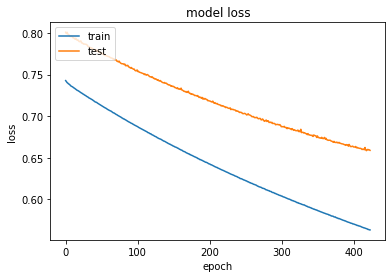

In [ ]:
#Plot train & validation loss
from matplotlib import pyplot as plt

plt.plot(best_model.history.history['loss'])
plt.plot(best_model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Evaluate on test data
score = best_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

814/814 [==============================] - 2s 3ms/step - loss: 0.7513 - accuracy: 0.7865
Test loss: 0.7513005137443542
Test accuracy: 0.7864551544189453
